# Домашнее задание


Основаная задача - **построить хорошую тематическую модель с интерпретируемыми топиками с помощью BigARTM**.

1) сделайте нормализацию (если pymorphy2 работает долго используйте mystem или попробуйте установить быструю версию - `pip install pymorphy2[fast]`, можно использовать какой-то другой токенизатор) 

2) добавьте нграммы (в тетрадке есть закомменченая ячейка с Phrases, можно также попробовать другие способы построить нграммы); 

3) сохраните тексты .vw формате;

4) сделайте хороший словарь (отфильтруйте слишком частотные и редкие слова, попробуйте удалить стоп-слова, сохраните словарь и посмотрите на него, вдруг что-то плохое сразу будет заметно - из словаря можно просто вручную или правилом удалять строки, при загрузке ничего не сломается); 

5) постройте несколько ARTM моделей (переберите количество тем, поменяйте значения tau у регуляризаторов), если получаются плохие темы, поработайте дополнительно над предобработкой и словарем; 

6) для самой хорошей модели в отдельной ячейке напечатайте 3 хороших (на ваш вкус) темы

7) в другой ячейке нарисуйте график обучения этой модели 

8) в третьей ячейки опишите какие параметры (количество тем, регуляризаторы, их tau) вы использовали и как обучали (например, после скольки проходов добавили регуляризатор разрежнивания тем (Phi), добавляли ли разреженность документам (Theta) и когда, как повышали значения, сколько итерации модель продожала улучшаться (снижалась перплексия, росли другие метрики);

Сохраните тетрадку с экспериментами и положите её на гитхаб, ссылку на неё укажите в форме.

**Оцениваться будут главным образом пункты 6, 7 и 8. (3, 1, 4 баллов соответственно). Чтобы заработать остальные 2 балла, нужно хотя бы немного изменить мой код на промежуточных этапах (добавить что-то, указать другие параметры и т.д). **

# 1) сделайте нормализацию (если pymorphy2 работает долго используйте mystem или попробуйте установить быструю версию - `pip install pymorphy2[fast]`, можно использовать какой-то другой токенизатор) 

In [4]:
!pip install bigartm

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 1.9 MB 1.4 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [5]:
import artm
%matplotlib inline
import glob
import os, re
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from nltk.corpus import stopwords
import numpy as np
from pymorphy2 import MorphAnalyzer
import gensim, nltk
import string
morph = MorphAnalyzer()
from nltk.tokenize import word_tokenize

/home/yudina/.local/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [6]:
nltk.download('punkt');nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/yudina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/yudina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
stops = set(stopwords.words('russian'))


def opt_normalize(texts, top=None):
    uniq = Counter()
    for text in texts:
        uniq.update(text)
    
    norm_uniq = {word:morph.parse(word.replace(':', ''))[0].normal_form for word, _ in uniq.most_common(top)}
    
    norm_texts = []
    for text in texts:
        
        norm_words = [norm_uniq.get(word) for word in text]
        norm_words = [word for word in norm_words if word and word not in stops]
        norm_texts.append(norm_words)
        
    return norm_texts

def tokenize(text):
    words = [word.strip(string.punctuation) for word in text.split()]
    words = [word for word in words if word]
    
    return words

In [8]:
texts = open('wiki_data.txt').read().splitlines()
texts = opt_normalize([tokenize(text.lower()) for text in texts], 30000)

# 2) добавьте нграммы (в тетрадке есть закомменченая ячейка с Phrases, можно также попробовать другие способы построить нграммы); 

In [55]:
# вернемся сюда через какое-то время
ph = gensim.models.Phrases(texts, scoring='npmi', threshold=0.3, 
                            common_terms=set(stopwords.words('russian'))) # можно указать слова, которые 
                                                                          # не будут учитываться
p = gensim.models.phrases.Phraser(ph)
ngrammed_texts = p[texts]

In [56]:
p[texts[1]]

['фильм',
 '—',
 'немой_короткометражный',
 'драматический',
 'фильм_режиссёр',
 'фильм_снятой',
 'роман',
 'виктор',
 'состояться',
 'франция',
 '1905_год',
 'фильм',
 'считаться_самый',
 'фильм',
 'роман',
 'парижский',
 'рассказывать',
 'жизнь',
 'красавица',
 'собор',
 'парижский',
 'богоматерь']

# 3) сохраните тексты .vw формате;

In [57]:
f = open('wiki_texts.vw', 'w')

for i, text in enumerate(ngrammed_texts):
    c = Counter(text)
    doc = 'doc_'+ str(i) + ' '
    vw_text = ' '.join([x+':'+str(c[x]) for x in c])
    
    f.write(doc + vw_text  + '\n')
f.close()

In [58]:
def print_measures(model_artm):
    print('Sparsity Phi: {0:.3f} ARTM)'.format(
        model_artm.score_tracker['SparsityPhiScore'].last_value)
)
    print('Sparsity Theta: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['SparsityThetaScore'].last_value))

    print('Kernel contrast: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['TopicKernelScore'].last_average_contrast))

    print('Kernel purity: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['TopicKernelScore'].last_average_purity))

    print('Perplexity: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['PerplexityScore'].last_value)
)
    plt.plot(range(model_artm.num_phi_updates), model_artm.score_tracker['PerplexityScore'].value, 'r--', linewidth=2)
    plt.xlabel('Iterations count')
    plt.ylabel(' ARTM perp. (red)')
    plt.grid(True)
    plt.show()
    

In [59]:
batch_vectorizer = artm.BatchVectorizer(data_path='wiki_texts.vw',  # название файла
                                        data_format='vowpal_wabbit', # формат файла, у нас vw
                                        target_folder='batches', # название папки в которую положаться батчи
                                       batch_size=1000) # размер батча, подбирайте под свою память

In [60]:
batch_vectorizer = artm.BatchVectorizer(data_path='batches', # название папки с батчами
                                        data_format='batches') # указываем формат - батчи

# 4) сделайте хороший словарь (отфильтруйте слишком частотные и редкие слова, попробуйте удалить стоп-слова, сохраните словарь и посмотрите на него, вдруг что-то плохое сразу будет заметно - из словаря можно просто вручную или правилом удалять строки, при загрузке ничего не сломается); 

In [83]:
# инициализируем словарь, чтобы сделать модель
dictionary = artm.Dictionary()

In [84]:
dictionary.gather(data_path='batches')
dictionary.filter(class_id='@default_class',
                  min_df=100, max_df=2000, max_dictionary_size=1500)

artm.Dictionary(name=159db444-98ee-43ef-9b7f-4bad677ea8c2, num_entries=1493)

In [85]:
dictionary.save_text('dict.txt')
# dictionary = artm.Dictionary()
# dictionary.load_text('dict.txt')

# 5) постройте несколько ARTM моделей (переберите количество тем, поменяйте значения tau у регуляризаторов), если получаются плохие темы, поработайте дополнительно над предобработкой и словарем; 

In [86]:
def model_artm(n_topics, tau_d, tau_s, dictionary):

    model = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(n_topics)],

                           regularizers=[
                               artm.DecorrelatorPhiRegularizer(
                                                name='Decorr', tau=0.25, 
                                                class_ids=['@default_class'],
                                                topic_names=['topic_{}'.format(i) for i in range(0, n_topics)]),

                               artm.SmoothSparsePhiRegularizer(
                                                name='SmoothPhi_1', 
                                                class_ids=['@default_class'],
                                                tau=0.15, 
                                                topic_names=['topic_{}'.format(i) for i in range(0, n_topics)])
                                        ]
                            )
    # инициализурем модель словарем
    model.initialize(dictionary=dictionary, )
    # добавляем метрики
    model.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary))
    model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore')) # разреженность слов в темах
    model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore')) # разреженность тем в доках
    model.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.1)) # когерентность по семантичесим ядрам
    model.scores.add(artm.TopTokensScore(class_id='@default_class', name='TopTokensScore_1', num_tokens=10)) # топ-n-слов для каждой темы 
    
    
    return model 

# не забывайте менять количество топиков в регуляризаторах, они применяются только на тех темах, что заданы

In [94]:
model_1 = model_artm(200, 0.25, 0.15, dictionary)

In [95]:
def train(model, num_document_passes, batch_vectorizer, num_collection_passes):
    model.num_document_passes = num_document_passes
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=num_collection_passes)
    # посмотрим, что стало с моделью
    # если график сильно падал на последних итерациях, то можно прогнать обучение ещё несколько раз 
    # (не добавляя другие регуляризаторы)
    print_measures(model)
    
    return model

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.007 (ARTM)
Kernel purity: 0.005 (ARTM)
Perplexity: 1130.746 (ARTM)


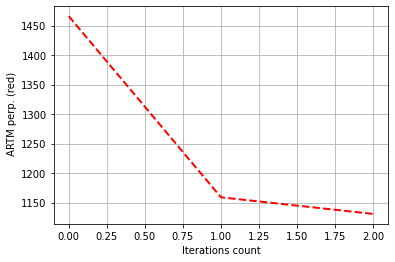

In [96]:
model_1 = train(model_1, 2, batch_vectorizer, 3)

In [99]:
def train_reg(model, n, n_topics, tau, batch_vectorizer, num_collection_passes):
    model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=tau, 
                                                            topic_names=['topic_{}'.format(i) for i in range(1, n_topics)],
                                                            ))
    model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=tau, 
                                                              topic_names=['topic_{}'.format(i) for i in range(1, n_topics)]))
    model.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=num_collection_passes)
    
    # будем постепенно увеличивать значения этих регуляризаторов
    phi_tau = model.regularizers['SparsePhi'].tau
    theta_tau = model.regularizers['SparseTheta'].tau

    for i in range(n):
        model.regularizers['SparsePhi'].tau = (phi_tau + (phi_tau*0.5))
        model.regularizers['SparseTheta'].tau = (theta_tau + (theta_tau*0.1))

        model.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=num_collection_passes)

    print_measures(model)
    return model

Sparsity Phi: 0.904 ARTM)
Sparsity Theta: 0.850 (ARTM)
Kernel contrast: 0.755 (ARTM)
Kernel purity: 0.810 (ARTM)
Perplexity: 254.580 (ARTM)


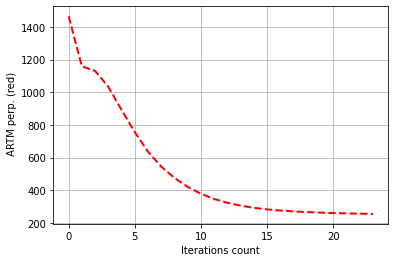

In [98]:
model_1 = train_reg(model_1, 20, 200, -0.15, batch_vectorizer, 1)

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.027 (ARTM)
Kernel purity: 0.011 (ARTM)
Perplexity: 1122.840 (ARTM)


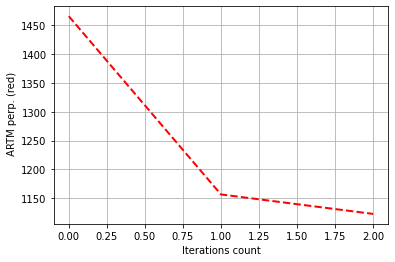

Sparsity Phi: 0.822 ARTM)
Sparsity Theta: 0.763 (ARTM)
Kernel contrast: 0.572 (ARTM)
Kernel purity: 0.805 (ARTM)
Perplexity: 349.358 (ARTM)


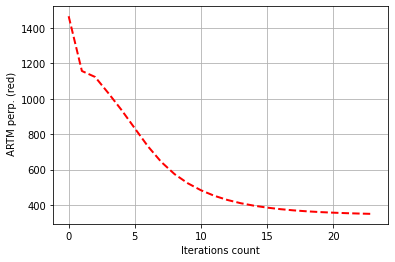

In [103]:
n_topics = 100
model_2 = model_artm(n_topics, 0.25, 0.15, dictionary)
model_2 = train(model_2, 2, batch_vectorizer, 3)
model_2 = train_reg(model_2, 20, n_topics, -0.15, batch_vectorizer, 1)

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.013 (ARTM)
Kernel purity: 0.007 (ARTM)
Perplexity: 1127.950 (ARTM)


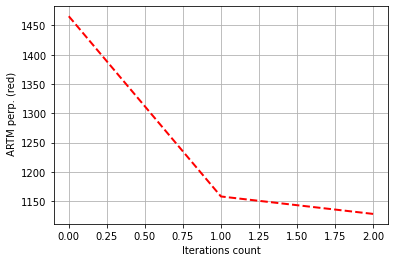

Sparsity Phi: 0.875 ARTM)
Sparsity Theta: 0.819 (ARTM)
Kernel contrast: 0.677 (ARTM)
Kernel purity: 0.802 (ARTM)
Perplexity: 293.079 (ARTM)


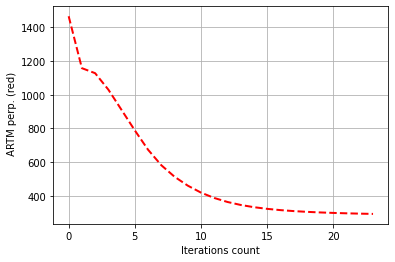

In [104]:
n_topics = 150
model_3 = model_artm(n_topics, 0.25, 0.15, dictionary)
model_3 = train(model_3, 2, batch_vectorizer, 3)
model_3 = train_reg(model_3, 20, n_topics, -0.15, batch_vectorizer, 1)

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.004 (ARTM)
Kernel purity: 0.004 (ARTM)
Perplexity: 1134.027 (ARTM)


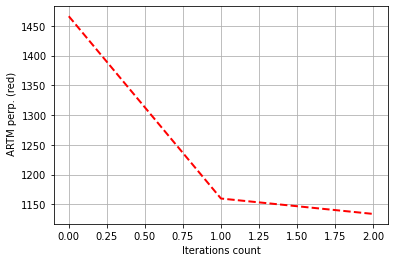

Sparsity Phi: 0.919 ARTM)
Sparsity Theta: 0.870 (ARTM)
Kernel contrast: 0.793 (ARTM)
Kernel purity: 0.807 (ARTM)
Perplexity: 227.810 (ARTM)


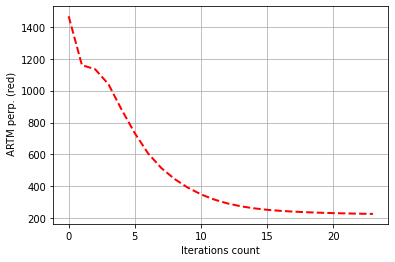

In [105]:
n_topics = 250 # Лучшая модель по n_topics, не буду больше менять параметр
model_4 = model_artm(n_topics, 0.25, 0.15, dictionary)
model_4 = train(model_4, 2, batch_vectorizer, 3)
model_4 = train_reg(model_4, 20, n_topics, -0.15, batch_vectorizer, 1)

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.004 (ARTM)
Kernel purity: 0.004 (ARTM)
Perplexity: 1134.027 (ARTM)


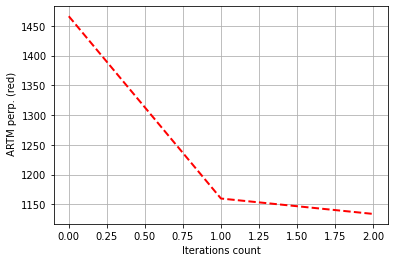

Sparsity Phi: 0.919 ARTM)
Sparsity Theta: 0.870 (ARTM)
Kernel contrast: 0.793 (ARTM)
Kernel purity: 0.807 (ARTM)
Perplexity: 227.810 (ARTM)


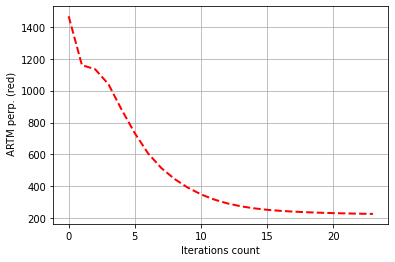

In [107]:
n_topics = 250 
model_5 = model_artm(n_topics, 0.35, 0.15, dictionary)
model_5 = train(model_5, 2, batch_vectorizer, 3)
model_5 = train_reg(model_5, 20, n_topics, -0.15, batch_vectorizer, 1)

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.004 (ARTM)
Kernel purity: 0.004 (ARTM)
Perplexity: 1134.027 (ARTM)


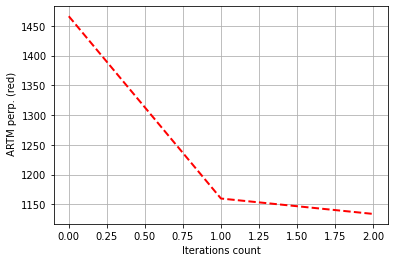

Sparsity Phi: 0.919 ARTM)
Sparsity Theta: 0.870 (ARTM)
Kernel contrast: 0.793 (ARTM)
Kernel purity: 0.807 (ARTM)
Perplexity: 227.810 (ARTM)


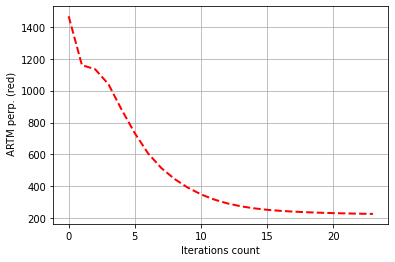

In [108]:
n_topics = 250 
model_6 = model_artm(n_topics, 0.15, 0.15, dictionary) # первое tau не повлияло на Perplexity
model_6 = train(model_6, 2, batch_vectorizer, 3)
model_6 = train_reg(model_6, 20, n_topics, -0.15, batch_vectorizer, 1)

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.004 (ARTM)
Kernel purity: 0.004 (ARTM)
Perplexity: 1134.027 (ARTM)


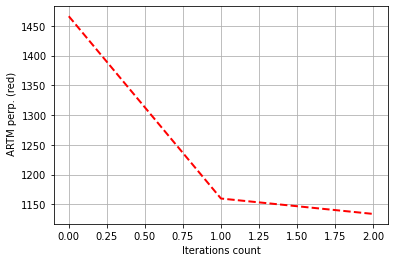

Sparsity Phi: 0.919 ARTM)
Sparsity Theta: 0.870 (ARTM)
Kernel contrast: 0.793 (ARTM)
Kernel purity: 0.807 (ARTM)
Perplexity: 227.810 (ARTM)


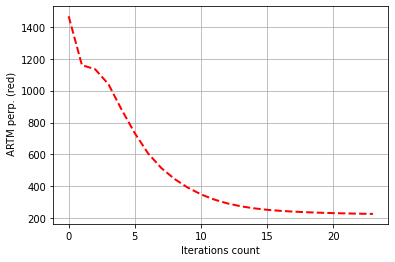

In [109]:
n_topics = 250 
model_7 = model_artm(n_topics, 0.15, 0.45, dictionary) # второе tau тоже особо не влияет
model_7 = train(model_7, 2, batch_vectorizer, 3)
model_7 = train_reg(model_7, 20, n_topics, -0.15, batch_vectorizer, 1)

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.008 (ARTM)
Kernel contrast: 0.038 (ARTM)
Kernel purity: 0.027 (ARTM)
Perplexity: 896.008 (ARTM)


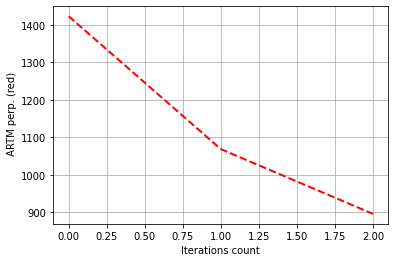

Sparsity Phi: 0.920 ARTM)
Sparsity Theta: 0.885 (ARTM)
Kernel contrast: 0.692 (ARTM)
Kernel purity: 0.778 (ARTM)
Perplexity: 226.937 (ARTM)


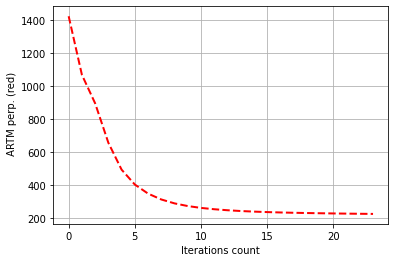

In [111]:
n_topics = 250 
model_8 = model_artm(n_topics, 0.15, 0.45, dictionary) 
model_8 = train(model_8, 6, batch_vectorizer, 3) # увеличение num_document_passes улучшило Perplexity
model_8 = train_reg(model_8, 20, n_topics, -0.15, batch_vectorizer, 1)

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.060 (ARTM)
Kernel contrast: 0.234 (ARTM)
Kernel purity: 0.200 (ARTM)
Perplexity: 445.086 (ARTM)


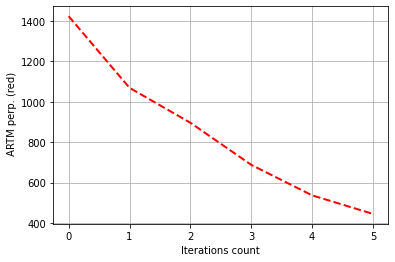

Sparsity Phi: 0.930 ARTM)
Sparsity Theta: 0.883 (ARTM)
Kernel contrast: 0.703 (ARTM)
Kernel purity: 0.801 (ARTM)
Perplexity: 225.447 (ARTM)


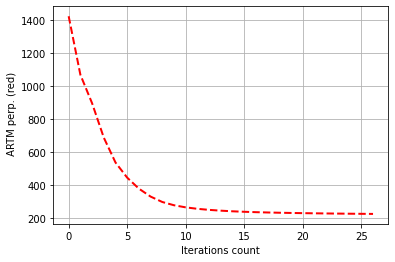

In [112]:
n_topics = 250 
model_9 = model_artm(n_topics, 0.15, 0.45, dictionary) 
model_9 = train(model_9, 6, batch_vectorizer, 6) # увеличение num_collection_passes улучшило Perplexity
model_9 = train_reg(model_9, 20, n_topics, -0.15, batch_vectorizer, 1)

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.060 (ARTM)
Kernel contrast: 0.234 (ARTM)
Kernel purity: 0.200 (ARTM)
Perplexity: 445.086 (ARTM)


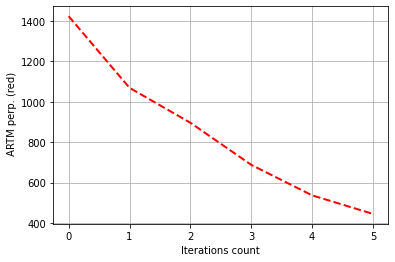

Sparsity Phi: 0.951 ARTM)
Sparsity Theta: 0.880 (ARTM)
Kernel contrast: 0.729 (ARTM)
Kernel purity: 0.834 (ARTM)
Perplexity: 221.485 (ARTM)


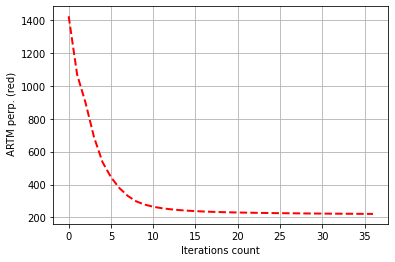

In [113]:
n_topics = 250 
model_10 = model_artm(n_topics, 0.15, 0.45, dictionary) 
model_10 = train(model_10, 6, batch_vectorizer, 6) 
model_10 = train_reg(model_10, 30, n_topics, -0.15, batch_vectorizer, 1)  # увеличение шагов цикла улучшает Perplexity

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.060 (ARTM)
Kernel contrast: 0.234 (ARTM)
Kernel purity: 0.200 (ARTM)
Perplexity: 445.086 (ARTM)


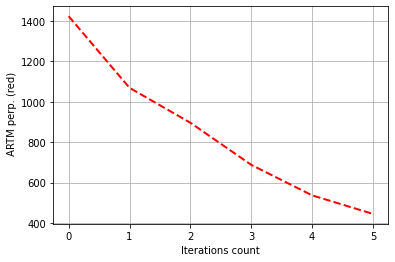

Sparsity Phi: 0.935 ARTM)
Sparsity Theta: 0.910 (ARTM)
Kernel contrast: 0.548 (ARTM)
Kernel purity: 0.677 (ARTM)
Perplexity: 253.410 (ARTM)


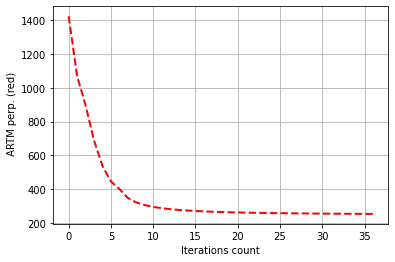

In [114]:
n_topics = 250 
model_11 = model_artm(n_topics, 0.15, 0.45, dictionary) 
model_11 = train(model_11, 6, batch_vectorizer, 6) 
model_11 = train_reg(model_11, 30, n_topics, -0.45, batch_vectorizer, 1) # уменьшение tau ухудшило Perplexity

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.060 (ARTM)
Kernel contrast: 0.234 (ARTM)
Kernel purity: 0.200 (ARTM)
Perplexity: 445.086 (ARTM)


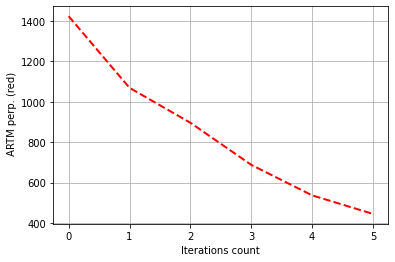

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.002 (ARTM)
Kernel contrast: 0.675 (ARTM)
Kernel purity: 0.712 (ARTM)
Perplexity: 339.835 (ARTM)


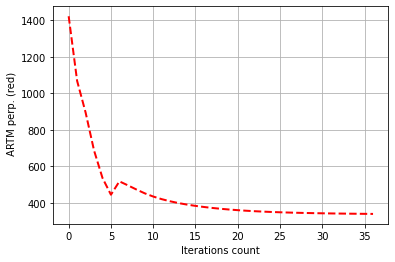

In [115]:
n_topics = 250 
model_12 = model_artm(n_topics, 0.15, 0.45, dictionary) 
model_12 = train(model_12, 6, batch_vectorizer, 6) 
model_12 = train_reg(model_12, 30, n_topics, 0.15, batch_vectorizer, 1) # увеличение тоже ухудшило 

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.060 (ARTM)
Kernel contrast: 0.234 (ARTM)
Kernel purity: 0.200 (ARTM)
Perplexity: 445.086 (ARTM)


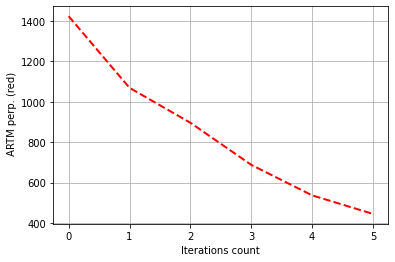

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.867 (ARTM)
Kernel contrast: 0.772 (ARTM)
Kernel purity: 0.873 (ARTM)
Perplexity: 219.302 (ARTM)


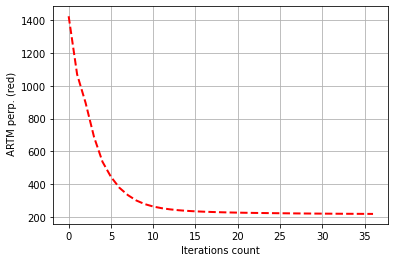

In [116]:
n_topics = 250 
model_13 = model_artm(n_topics, 0.15, 0.45, dictionary) 
model_13 = train(model_13, 6, batch_vectorizer, 6) 
model_13 = train_reg(model_13, 30, n_topics, -0.05, batch_vectorizer, 1) # а небольшое увеличение улучшило

# 7) в другой ячейке нарисуйте график обучения этой модели 

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.060 (ARTM)
Kernel contrast: 0.234 (ARTM)
Kernel purity: 0.200 (ARTM)
Perplexity: 445.086 (ARTM)


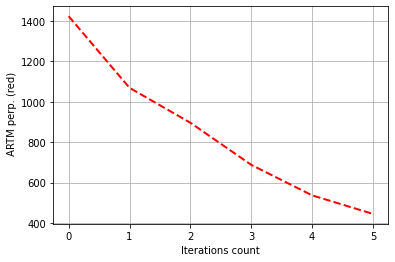

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.864 (ARTM)
Kernel contrast: 0.815 (ARTM)
Kernel purity: 0.916 (ARTM)
Perplexity: 214.841 (ARTM)


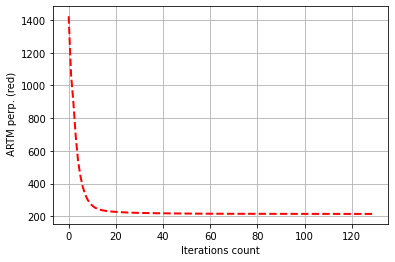

In [119]:
n_topics = 250 
model_14 = model_artm(n_topics, 0.15, 0.45, dictionary) 
model_14 = train(model_14, 6, batch_vectorizer, 6) 
model_14 = train_reg(model_14, 30, n_topics, -0.05, batch_vectorizer, 4) # увеличение num_collection_passes улучшило Perplexity

# 6) для самой хорошей модели в отдельной ячейке напечатайте 3 хороших (на ваш вкус) темы

In [120]:
# посмотрим на темы
for topic_name in model_14.topic_names[:50]:
    print(topic_name + ': ')
    try:
        for x in model_14.score_tracker['TopTokensScore_1'].last_tokens[topic_name]:
            print(x)
        print('---------')
    
    except KeyError: # можно перекрутить параметры и некоторые темы окажутся пустыми
        continue

topic_0: 
университет
исследование
наука
научный
учёный
изучение
студент
исследователь
изучать
провести
---------
topic_1: 
январь
декабрь
ноябрь
октябрь
перейти
вместо
выйти
произойти
принять
войти
---------
topic_2: 
император
личный
отправить
царь
бежать
приказ
двор
принять
историк
дворец
---------
topic_3: 
деятельность
база
действовать
подготовка
формирование
подразделение
обеспечение
вестись
осуществляться
восстановление
---------
topic_4: 
немецкий
фон
карл
соединение
активно
принять
близкий
успеть
дух
принести
---------
topic_5: 
высокий
плата
санкт-петербург
литр
принять
широкий
вплоть
качество
последующий
провести
---------
topic_6: 
хороший
внутренний
сложный
управлять
изначально
самостоятельный
сразу
соответственно
похожий
продолжать
---------
topic_7: 
занимать
должность
пост
великий
возглавить
вступить
великое
орден
назначение
сменить
---------
topic_8: 
школа
учиться
обучение
учитель
преподавать
учебный
директор
ученик
продолжать
преобразовать
---------
topic_9: 
век
сло

Мне понравились следующие темы:

1) topic_0: Образование ВУЗ

университет
исследование
наука
научный
учёный
изучение
студент
исследователь
изучать
провести

2) topic_8: Образование школа

школа
учиться
обучение
учитель
преподавать
учебный
директор
ученик
продолжать
преобразовать

3) topic_44: Кино


фильм
режиссёр
актёр
снять
студия
сцена
картина
выйти
снятой
актриса

# 8) в третьей ячейки опишите какие параметры (количество тем, регуляризаторы, их tau) вы использовали и как обучали (например, после скольки проходов добавили регуляризатор разрежнивания тем (Phi), добавляли ли разреженность документам (Theta) и когда, как повышали значения, сколько итерации модель продожала улучшаться (снижалась перплексия, росли другие метрики);

250 тем

У регуляризаторов, которые были включены сразы (Декореляция и Сглаживание) tau соответствено равны 0.15, 0.45. 
При первом обучении num_document_passes и num_collection_passes равные 6. При втором обучении у меня было 30 шагов в цикле, tau -0.05 для SparsePhi и SparseTheta регуляризаций и num_collection_passes = 4.

Для подбора этих параметров я последовательно меняла в моделях по одному параметру, затем брала за основу лучшую модель и начинала перебирать другие параметры. 